<a href="https://colab.research.google.com/github/Gauravv97/flownet2-Colab/blob/master/Flownet2_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Install FlowNet2

## Download compatible Torch

In [ ]:
!pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html

## Download and setup FlowNet2 files

In [2]:
import os
# get flownet2-pytorch source
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!mv /content/flownet2-pytorch /content/flownet2pytorch
os.chdir('./flownet2pytorch')
# install custom layers
!bash install.sh

Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 557, done.
remote: Total 557 (delta 0), reused 0 (delta 0), pack-reused 557
Receiving objects: 100% (557/557), 6.28 MiB | 2.86 MiB/s, done.
Resolving deltas: 100% (311/311), done.


### Add packages to IPython system path

In [12]:
import os
os.sys.path.append('/root/.local/lib/python3.6/site-packages/resample2d_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.6/site-packages/correlation_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.6/site-packages/channelnorm_cuda-0.0.0-py3.6-linux-x86_64.egg')

# Download files and Install Packages

In [ ]:
!pip install scipy==1.1.0
!pip install pypng

In [32]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da',dest_path='./FlowNet2_checkpoint.pth.tar')

# Run the inference

### Downloading sample video. You can upload your own video named video.mp4 in the folder flownet2pytorch

In [ ]:
gdd.download_file_from_google_drive(file_id='18kfA8pQyXCN-Tk6HREbgZL6mKPttJ3cg',dest_path='./video.mp4')

### Converting video to frames

In [8]:
import os
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

In [9]:
vid_file='./video.mp4'
frame_pth='./frames'
mkdir_ifnotexists(frame_pth)
cmd = "ffmpeg -i %s -start_number 0 -vsync 0 %s/frame_%%06d.png" % (
            vid_file,
            frame_pth,
        )
os.system(cmd)

0

### Generate .flo files using FlowNet2

In [ ]:
!python main.py --inference --model FlowNet2 --save_flow --save ./output --inference_dataset ImagesFromFolder --inference_dataset_root ./frames/ --resume ./FlowNet2_checkpoint.pth.tar

# Visualizing flo files

### Install scipy and **Restart the Runtime** as some tensorflow functionality requires updated scipy

In [132]:
!pip install scipy==1.4.1

     |████████████████████████████████| 26.1MB 116kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.5.2
    Uninstalling scipy-1.5.2:
      Successfully uninstalled scipy-1.5.2


In [5]:
os.chdir('./flownet2pytorch')

### Define show_flow() for visualization.
 Original Source https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py

In [10]:
# Source:https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py
import matplotlib.pyplot as plt
UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

### Visualize

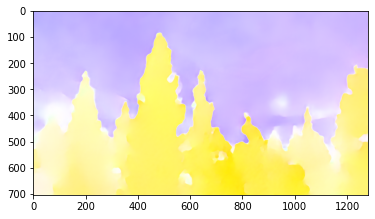

In [21]:
show_flow('/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/000001.flo')

### Save Flo files as images

In [13]:
import os
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

import scipy.misc
flo_pth='/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/'
flos=[flo_pth + f for f in os.listdir(flo_pth)]
mkdir_ifnotexists('./FlowFrames')
for i in range(len(flos)):
  scipy.misc.imsave('./FlowFrames/'+os.path.basename(flos[i])+'.png', flow_to_image(read_flow(flos[i])))

### Generate video from Flo

In [28]:
os.system('ffmpeg -r 24 -i FlowFrames/%6d.flo.png -vcodec libx264 -b 10M -y FlowVideo.mp4  ')

0

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('FlowVideo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Warp Images using flow

In [3]:
import tensorflow as tf
import PIL.Image
import numpy as np
def load_img(path_to_img,max_dim = 0):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  if max_dim==0:
      scale=1
  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img
def tensor_to_image(tensor):
  tensor = tensor
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

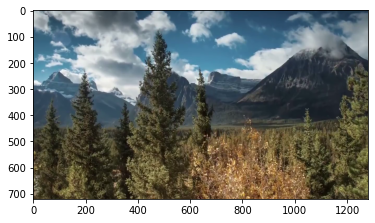

In [29]:
import tensorflow_addons as tfa
i=0
frames=['frames/' + f for f in os.listdir('./frames/')]
frames.sort()
input_img = load_img(frames[1])
#if image/frame size is not divisible by 2e5 then the generated flow size will be smaller and divisible by 2e5
#resize the flow to frame size
flos.sort()
flow=tf.image.resize(read_flow(flos[1]),img.shape[0:2],method='bilinear')
plt.imshow(tensor_to_image(tfa.image.dense_image_warp( input_img, tf.expand_dims(flow,0))*255))

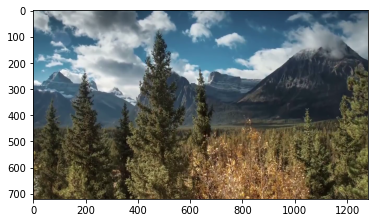

In [30]:
plt.imshow(tensor_to_image(load_img(frames[1])*255))

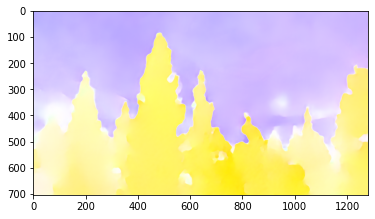

In [19]:
show_flow(flos[1])